# Objective
Forecasting demand or expecting the number of passengers that will travel on a certain itinerary between any two city-pairs is an essential task for any airline to do. 


# Market share model aid airlines in:

- Performing merger and acquisition strategies.
- Route schedule analysis.
- Price-elasticity studies.
- Performing airline operations as fleet assignment and aircraft routing.


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Jun/2022 22:24:21] "OPTIONS /MarketShare HTTP/1.1" 200 -
No handles with labels found to put in legend.


Generated Itineraries are:
[['5'], ['19'], ['21', '38'], ['21', '39', '40']]

Number_of_Itineraries_Generated
4

------------------------------------------------------------


The Assigned Passengers for Itinerary 2 will be "300" 

The Assigned Passengers for Itinerary 1 will be "227" 

The Assigned Passengers for Itinerary 3 will be "114" 

The Assigned Passengers for Itinerary 4 will be "60" 



------------------------------------------------------------


The QSI for Airline Y will be 32.38 % 

The QSI for Airline Z will be 42.8 % 

The QSI for Airline X will be 24.82 % 

------------------------------------------------------------


HHI
0.3218


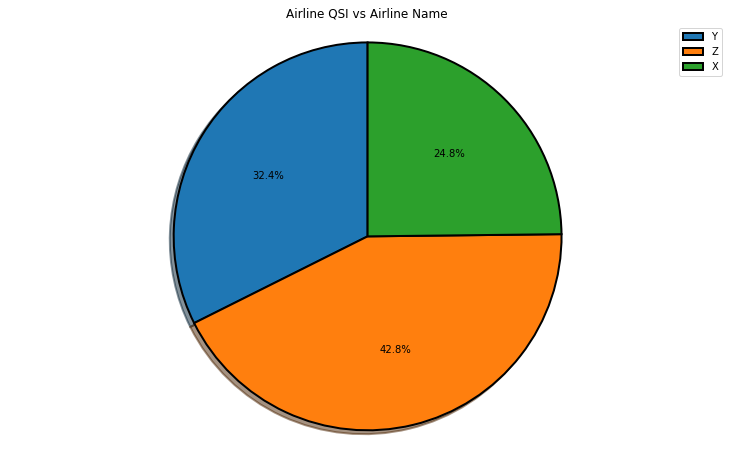

127.0.0.1 - - [20/Jun/2022 22:24:24] "POST /MarketShare HTTP/1.1" 200 -


{'Itinerary': [['5'], ['19'], ['21', '38'], ['21', '39', '40']], 'No_of_Itineraries_Gen': [4], 'Itinerary_index_Ans': [2, 1, 3, 4], 'Itinerary_Market_Share': [300, 227, 114, 60], 'Airline_Comp': ['Y', 'Z', 'X'], 'Airline_QSI': [32.38, 42.8, 24.82], 'HHI': [0.3218], 'companies_index': ['Z', 'Y', 'X', 'X']}


In [ ]:
import math
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from random import randint
from random import uniform
import itertools
from itertools import permutations, product
from mip import Model, xsum, maximize, minimize, BINARY, INTEGER
from flask import Flask, jsonify
from flask_restful import Api, Resource, reqparse
from flask_cors import CORS
from flask import Flask, Blueprint
from flask_cors import CORS
from flask_restful import Resource, Api
import config
import matplotlib.pyplot as plt

############################################# INPUTS #####################################################
# Api
app = Flask(__name__)
CORS(app)
api = Api(app)

class MarketShare(Resource):
        
    def post(self):
        parser = reqparse.RequestParser()
        parser.add_argument('data', type = dict)                     
        parser.add_argument('dataMLE', type = dict) 
        parser.add_argument('xdata', type = dict)                             
        parser.add_argument('Origin', type = str)                            
        parser.add_argument('Destination', type = str)
        parser.add_argument('Demand', type = int)  
        args = parser.parse_args()
#         print(args)

        data = args['data']
        dataMLE = args['dataMLE']
        xdata = args['xdata']
        Origin = args['Origin']
        Destination = args['Destination']
        Demand = args['Demand']
#         print(data)
#         print('-'*30)
#         print(dataMLE)
#         print('-'*30)
#         print(xdata)
#         print('-'*30)
#         print(Origin, Destination, Demand)
        
        data = pd.DataFrame(data['data'])
        dataMLE = pd.DataFrame(dataMLE['data'])
        xdata = pd.DataFrame(xdata['data'])
        for i in range (1,48):
            dataMLE[f'x{i}'] = dataMLE[f'x{i}'].astype(float)   
        dataMLE['Booking Data'] = dataMLE['Booking Data'].astype(float)
        data['Distance (km)'] = data['Distance (km)'].astype(float)
        data['Capacity'] = data['Capacity'].astype(float)
        data['Fare'] = data['Fare'].astype(float)
        xdata['x_passengers'] = xdata['x_passengers'].astype(float)

#         print(data)
#         print('-'*30)
#         print(dataMLE)
#         print('-'*30)
#         print(xdata)
#         print('-'*30)
#         print(Origin, Destination, Demand)




        ########################################## Itinerary Builder ################################################

        data['Departure time date'] = pd.to_datetime(data['Departure time'])
        data['Arrival Time date'] = pd.to_datetime(data['Arrival Time'])

        Min_Connection_Time_hour = dt.time(0, 0, 0).hour
        Min_Connection_Time_one_hour = dt.time(1, 0, 0).hour
        Min_Connection_Time_minute = dt.time(0, 30, 0).minute

        Max_Connection_Time_hour = dt.time(2, 0, 0).hour

        # Get the companies of the data
        company = np.array(data['Company'].unique())
        #print('Companies: \n', company , end='\n\n')
        #print('...', end='\n\n' )

        Itinerary = []
        Num_of_connecting_flights = []
        Capacity = []
        Companies = []

        for p in range(len(company)):
            df = data[data['Company'] == company[p]]
            # print('Filtered data: \n', df, end='\n\n')

            Itinerary0 = []
            Num_of_connecting_flights0 = []
            Capacity0 = []

            for i, row in df.iterrows():
                ori1 = df['Origin'][i]
                dest1 = df['Destination'][i]
                Dep_time1 = df['Departure time'][i]
                Dep_time_date1 = df['Departure time date'][i]
                Arr_time1 = df['Arrival Time'][i]
                Arr_time_date1 = df['Arrival Time date'][i]
                F_no1 = df['Flight Number'][i]
                Distance1 = df['Distance (km)'][i]
                AC_Type1 = df['Aircraft Type'][i]
                Capacity1 = df['Capacity'][i]
                if ori1 == Origin and dest1 == Destination:
                    Itinerary0.append([F_no1])
                    Num_of_connecting_flights0.append(0)
                    Capacity0.append(Capacity1)
                for ii, row in df.iterrows():
                    ori2 = df['Origin'][ii]
                    dest2 = df['Destination'][ii]
                    Dep_time2 = df['Departure time'][ii]
                    Dep_time_date2 = df['Departure time date'][ii]
                    Arr_time2 = df['Arrival Time'][ii]
                    Arr_time_date2 = df['Arrival Time date'][ii]
                    F_no2 = df['Flight Number'][ii]
                    Distance2 = df['Distance (km)'][ii]
                    AC_Type2 = df['Aircraft Type'][ii]
                    Capacity2 = df['Capacity'][ii]
                    if ori1 == Origin and dest2 == Destination:
                        Time_Difference_hour = datetime.strptime(Dep_time2, "%H:%M").hour - datetime.strptime(Arr_time1,
                                                                                                              "%H:%M").hour
                        Time_Difference_minute = datetime.strptime(Dep_time2, "%H:%M").minute - datetime.strptime(Arr_time1,
                                                                                                                  "%H:%M").minute
                        Time_Difference_Max = datetime.strptime(Dep_time2, "%H:%M").hour - datetime.strptime(Arr_time1,
                                                                                                             "%H:%M").hour
                        Total_Distance = Distance1 + Distance2
                        if dest1 == ori2 and Dep_time_date2 > Arr_time_date1 and Total_Distance <= 300:
                            if (
                                    Time_Difference_hour == Min_Connection_Time_hour and Time_Difference_minute >= Min_Connection_Time_minute and Time_Difference_Max <= Max_Connection_Time_hour) or (
                                    Time_Difference_hour == Min_Connection_Time_one_hour):
                                Itinerary0.append([F_no1, F_no2])
                                Num_of_connecting_flights0.append(1)
                                Capacity0.append([Capacity1, Capacity2])
                    for iii, row in df.iterrows():
                        ori3 = df['Origin'][iii]
                        dest3 = df['Destination'][iii]
                        Dep_time3 = df['Departure time'][iii]
                        Dep_time_date3 = df['Departure time date'][iii]
                        Arr_time3 = df['Arrival Time'][iii]
                        Arr_time_date3 = df['Arrival Time date'][iii]
                        F_no3 = df['Flight Number'][iii]
                        Distance3 = df['Distance (km)'][iii]
                        AC_Type3 = df['Aircraft Type'][iii]
                        Capacity3 = df['Capacity'][iii]
                        if ori1 == Origin and dest3 == Destination:
                            Time_Difference_hour = datetime.strptime(Dep_time2, "%H:%M").hour - datetime.strptime(Arr_time1,
                                                                                                                  "%H:%M").hour
                            Time_Difference_minute = datetime.strptime(Dep_time2, "%H:%M").minute - datetime.strptime(Arr_time1,
                                                                                                                      "%H:%M").minute
                            Time_Difference_hour2 = datetime.strptime(Dep_time3, "%H:%M").hour - datetime.strptime(Arr_time2,
                                                                                                                   "%H:%M").hour
                            Time_Difference_minute2 = datetime.strptime(Dep_time3, "%H:%M").minute - datetime.strptime(
                                Arr_time2,
                                "%H:%M").minute
                            Time_Difference_Max = datetime.strptime(Dep_time2, "%H:%M").hour - datetime.strptime(Arr_time1,
                                                                                                                 "%H:%M").hour
                            Time_Difference_Max2 = datetime.strptime(Dep_time3, "%H:%M").hour - datetime.strptime(Arr_time2,
                                                                                                                  "%H:%M").hour
                            Total_Distance2 = Distance1 + Distance2 + Distance3
                            if dest1 == ori2 and ori3 == dest2 and Dep_time_date2 > Arr_time_date1 and Dep_time_date3 > Arr_time_date2 and Total_Distance2 <= 450:
                                if (
                                        Time_Difference_hour == Min_Connection_Time_hour and Time_Difference_minute >= Min_Connection_Time_minute and Time_Difference_Max <= Max_Connection_Time_hour) or (
                                        Time_Difference_hour == Min_Connection_Time_one_hour):
                                    if (
                                            Time_Difference_hour2 == Min_Connection_Time_hour and Time_Difference_minute2 >= Min_Connection_Time_minute and Time_Difference_Max2 <= Max_Connection_Time_hour) or (
                                            Time_Difference_hour2 == Min_Connection_Time_one_hour):
                                        Itinerary0.append([F_no1, F_no2, F_no3])
                                        Num_of_connecting_flights0.append(2)
                                        Capacity0.append([Capacity1, Capacity2, Capacity3])
            #print(Itinerary0)
            #print(Num_of_connecting_flights0)
            #print(Capacity0)
            #print("______________________________________________________________________________")
            for i in range(len(Itinerary0)):
                Itinerary.append(Itinerary0[i])
            for s in range(len(Itinerary0)):
                Companies.append(company[p])
            for i in range(len(Num_of_connecting_flights0)):
                Num_of_connecting_flights.append(Num_of_connecting_flights0[i])
            for i in range(len(Capacity0)):
                Capacity.append(Capacity0[i])
        # print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")

        # print(Itinerary)
        # print(Companies)
        # print(Num_of_connecting_flights)
        # print(Capacity)

        ######################################### Multinomial Regression Model ###########################################

        # Get the itineraries of the whole data
        classes1 = np.array(dataMLE['Itinerary'].unique())
        # print('Itineraries: \n', classes1, end='\n\n')

        No_of_iti = len(classes1)
        #print('No.of tineraries: \n', No_of_iti, end='\n\n')

        e = np.arange(np.size(classes1))+1

        for k in range(np.size(classes1)):
            dataMLE=dataMLE.replace(to_replace=classes1[k], value=e[k])
        #print(data, end='\n\n')

        # Model
        X_train, X_test, y_train, y_test = train_test_split(dataMLE[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47']], dataMLE['Itinerary'], test_size=0.02)

        model = linear_model.LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        # Intercept and Coefficients
        Bo = model.intercept_
        Bs = model.coef_
        #print('Bo: \n' , Bo , end='\n\n')
        #print('Bs: \n', Bs, end='\n\n')
        #print(np.shape(Bo))
        #print(np.shape(Bs))
        #print('...................................................', end='\n\n')




        ############################################# Calc uij & Prob  ############################################
        xarray= np.array(xdata)

        uij = []
        for j in range(len(Bo)):
            a = Bo[j]
            b = Bs[j]
            #print(a)
            #print(b)
            #print(c, end='\n\n')
            #print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$", end='\n\n')
            uij.append(a + np.dot(b, xarray))

        uij_array = np.array(uij)
        # print('uij array')
        # print(uij_array)

        # IMPORTANT NOTE #
        # *Arrange first the Itineraries according to its utility value from largest to smallest* #
        # General Constraint on Non-Stop, Single Connect and Double Connect, etc... #


        # 1- Itinerary Builder #
        # 2- Choose from Cairo to Alex #
        # 3- Display the available Itineraries #
        # 4- Get the Utility values for each Itinerary #
        # 5- Calculate the Probability for each Itinerary #
        # 6- Assume Total Demand from Cairo to Alex #
        # 7- List of Capacities of each Aicraft #



        ############################################ Rearrange the Indices #####################################################

        Itineraries = classes1
        Capacity_o = Capacity
        Flights = Itinerary
        companies = Companies

        ###############################################################################################

        Uij = uij
        #print(Uij)
        list_sorted = Uij.copy()
        list_sorted.sort(reverse=True)

        list_index = []
        for x in list_sorted:
            list_index.insert(0, Uij.index(x))
        list_index.reverse()
        #print(list_index)
        #print(list_sorted)

        ###############################################################################################

        Itineraries_index = []
        Capacity0 = []
        Flights_index = []
        companies_index = []

        for i in list_index:
            Capacity0.append(Capacity_o[i])

            Itineraries_index.append(Itineraries[i])

            Flights_index.append(Flights[i])

            companies_index.append(companies[i])

        # print(Capacity0)
        # print(Itineraries_index)
        # print(Flights_index)
        # print(companies_index)
        # #########################################################################################################################

        # Utility Values for each Itinerary and its Probability #

        Uij.sort(reverse=True)

        Original_Utility = Uij.copy()

        Uexp = []
        for u in Uij:
            Uexp.append(math.exp(u))

        Pij = []
        for u in Uexp:
            p = u / sum((Uexp))
            Pij.append(p)

        Original_Probabilities = Pij.copy()
        # print(Original_Probabilities)

        # Unconstrained Demand on each Itinerary #

        Unconst_Demand = []
        for j in Pij:
            Unconst_Demand.append(j * Demand)

        Unconst_Demand = [round(a) for a in Unconst_Demand]

        Original_Unconstrained_Demand = Unconst_Demand.copy()
        # print(Original_Unconstrained_Demand)

        # Assigning each passenger to each Itinerary corresponding to the higher probability #

        Itinerary_Market_Share = np.zeros((1, len(Unconst_Demand)), int)
        Itinerary_Market_Share = Itinerary_Market_Share[0]

        for j in range(len(Unconst_Demand)):

            # Non-Stop Itinerary #

            if np.size(Capacity0[j]) == 1:

                for i in range(Unconst_Demand[j]):

                    if i < Capacity0[j]:
                        Itinerary_Market_Share[j] = Itinerary_Market_Share[j] + 1

                    if i == Capacity0[j]:

                        Uexp[j] = 0

                        if Uexp[-1] != 0:

                            Pij = []
                            for u in Uexp:
                                p = u / sum((Uexp))
                                Pij.append(p)

                            Demand = Demand - Itinerary_Market_Share[j]

                            Unconst_Demand = []
                            for p in Pij:
                                Unconst_Demand.append(p * Demand)

                            Unconst_Demand = [round(a) for a in Unconst_Demand]

            # General for any Connected Itinerary #

            if np.size(Capacity0[j]) > 1:

                for i in range(Unconst_Demand[j]):

                    if i < min(Capacity0[j]):
                        Itinerary_Market_Share[j] = Itinerary_Market_Share[j] + 1

                    if i == min(Capacity0[j]):

                        Uexp[j] = 0

                        if Uexp[-1] != 0:

                            Pij = []
                            for u in Uexp:
                                p = u / sum((Uexp))
                                Pij.append(p)

                            Demand = Demand - Itinerary_Market_Share[j]

                            Unconst_Demand = []
                            for p in Pij:
                                Unconst_Demand.append(p * Demand)

                            Unconst_Demand = [round(a) for a in Unconst_Demand]

                        # Calculating QSI and HHI for each Itinerary or Airline #

        QSI = []

        for i in range(len(Itinerary_Market_Share)):
            QSI.append(Itinerary_Market_Share[i] / sum(Itinerary_Market_Share))

        QSI_sq = []

        for i in range(len(QSI)):
            QSI_sq.append(QSI[i] ** 2)

        HHI = round(sum(QSI_sq), 4)

        ################################################ DISPLAYING OUTPUTS #######################################################

        # print("\nOriginal_Probabilities")
        # print(Original_Probabilities)
        # print("\n")
        #
        # print("Original_Unconstrained_Demand")
        # print(Original_Unconstrained_Demand)
        # print("\n")
        #
        # print("Demand")
        # print(Demand)
        # print('\nUij')
        # print(Uij)
        # print('\nUexp')
        # print(Uexp)
        # print('\nPij')
        # print(Pij)
        # print('\nUnconst_Demand')
        # print(Unconst_Demand)

        # print('\nItinerary_Market_Share')
        # print(Itinerary_Market_Share)

        # print("\nQSI")
        # print(QSI)
        #
        # print("\nHHI")
        # print(HHI)

        # print("\n------------------------------------------------------------\n")
        # print("Results:")
        # print("--------")
        # for i in range(len(Itinerary_Market_Share)):
        #     print('\nThe Assigned Passengers for Itinerary {} will be "{}" '.format(list_index[i]+1,Itinerary_Market_Share[i]))
        #
        # print("\n")
        #
        # print("\n------------------------------------------------------------\n")


        ##################################################################################################
        n = len(company)
        lists = [[] for _ in range(n)]
        # for i in range(n):
        #     lists[i].append(10)


        for i in range(len(company)):

            for j in range(len(companies_index)):

                if company[i] == companies_index[j]:

                    lists[i].append(Itinerary_Market_Share[j])

            # print(company[i])
            # print(lists[i])



        # print(lists)
        # print('\n--------')

        Airline_Market_Share = []
        for i in range(len(lists)):

            Airline_Market_Share.append(sum(lists[i]))

            # print(company[i])
            # print(Airline_Market_Share[i])
        #########################################################################

        # for i in range(len(Airline_Market_Share)):
        #     print('\nThe Assigned Passengers for Airline {} will be "{}" '.format(company[i],Airline_Market_Share[i]))
        #
        # print("\n")
        #
        # print("\n------------------------------------------------------------\n")

        # Calculating QSI and HHI for each Itinerary or Airline #

        Airline_QSI = []
        Airline_Comp = []

        for i in range(len(Airline_Market_Share)):
            Airline_QSI.append((Airline_Market_Share[i] / sum(Airline_Market_Share))*100)
            Airline_Comp.append(company[i])

        Airline_QSI = [round(a,2) for a in Airline_QSI]

        Airline_QSI_sq = []

        for i in range(len(Airline_QSI)):
            Airline_QSI_sq.append(Airline_QSI[i] ** 2)

        Airline_HHI = round(sum(Airline_QSI_sq), 4)

        # print("\n___________")
        # print('\nArilines_QSI')
        # print(Airline_QSI)
        # print('\nHHI')
        # print(Airline_HHI)
        # print("\n___________")

        ################################################# OUTPUTS #################################################

        # Itineraries
        print("Generated Itineraries are:")
        print(Itinerary)
        No_of_Itineraries_Gen = len(Itinerary)
        print('\nNumber_of_Itineraries_Generated')
        print(No_of_Itineraries_Gen)
        print("\n------------------------------------------------------------\n")


        # The number of assigned passengers for each itinerary
        Itinerary_index_Ans = []

        for i in range(len(Itinerary_Market_Share)):
            print('\nThe Assigned Passengers for Itinerary {} will be "{}" '.format(list_index[i]+1,Itinerary_Market_Share[i]))
            Itinerary_index_Ans.append(list_index[i]+1)

        print("\n")

        print("\n------------------------------------------------------------\n")


        # QSI for each Airline
        for i in range(len(Airline_QSI)):
            print('\nThe QSI for Airline {} will be {} % '.format(Airline_Comp[i],Airline_QSI[i]))

        # print('\nAirlines_QSI')
        # print(Airline_Comp)
        # print(Airline_QSI)


        print("\n------------------------------------------------------------\n")

        # HHI
        print("\nHHI")
        print(HHI)
        HHI1 = []
        HHI1.append(HHI)



        # Pie chart, where the slices will be ordered and plotted counter-clockwise:

        # fig1, ax1 = plt.subplots()
        fig1 = plt.figure(figsize=(10,6))
        ax1 = fig1.add_axes([0.,0.,1.,1.])

        wedge_properties = {"edgecolor":"k",'linewidth': 2}

        ax1.pie(Airline_QSI, autopct='%1.1f%%', shadow=True, wedgeprops=wedge_properties, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax1.set_title('Airline QSI vs Airline Name')

        # plt.legend(title = "Airline Name")
        plt.legend(title = "Airline Name")
        ax1.legend( Airline_Comp)
        plt.savefig("pie.png")
        plt.show()
        
        No_of_Itineraries_Gen1 = []
        No_of_Itineraries_Gen1.append(No_of_Itineraries_Gen)
        Itinerary_Market_Share1 = Itinerary_Market_Share.tolist()
#         for i in Itinerary_Market_Share:
#             Itinerary_Market_Share1.append(i)
            
        print({'Itinerary': Itinerary, 'No_of_Itineraries_Gen': No_of_Itineraries_Gen1, 'Itinerary_index_Ans': Itinerary_index_Ans, 'Itinerary_Market_Share': Itinerary_Market_Share1, 'Airline_Comp': Airline_Comp, 'Airline_QSI': Airline_QSI, 'HHI': HHI1,'companies_index':companies_index})
#         return({'Itinerary': Itinerary, 'No_of_Itineraries_Gen': No_of_Itineraries_Gen1, 'Itinerary_index_Ans': Itinerary_index_Ans, 'Itinerary_Market_Share': Itinerary_Market_Share1, 'Airline_Comp': Airline_Comp, 'Airline_QSI': Airline_QSI, 'HHI': HHI1,'companies_index':companies_index})
#         print({'Itinerary': Itinerary, 'Itinerary_index_Ans': Itinerary_index_Ans, 'Itinerary_Market_Share': Itinerary_Market_Share1, 'Airline_Comp': Airline_Comp, 'Airline_QSI': Airline_QSI,'companies_index':companies_index})
    
        return({ 'Itinerary': Itinerary, 'No_of_Itineraries_Gen': No_of_Itineraries_Gen1,'Itinerary_Market_Share': Itinerary_Market_Share1, 'Itinerary_index_Ans': Itinerary_index_Ans, 'Airline_Comp': Airline_Comp,'Airline_QSI': Airline_QSI,'HHI': HHI1,'companies_index':companies_index})
    
api.add_resource(MarketShare, '/MarketShare')


   
if __name__ == '__main__':
    app.run()